In [40]:
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt

In [8]:
from fbprophet import Prophet

In [2]:
token = os.environ['oanda_access_token']
account = os.environ['oanda_account_id']

In [3]:
from oanda_bot import Bot

class MyBot(Bot):
    def strategy(self):
        fast_ma = self.sma(period=5)
        slow_ma = self.sma(period=25)
        # golden cross
        self.sell_exit = self.buy_entry = (fast_ma > slow_ma) & (
            fast_ma.shift() <= slow_ma.shift()
        )
        # dead cross
        self.buy_exit = self.sell_entry = (fast_ma < slow_ma) & (
            fast_ma.shift() >= slow_ma.shift()
        )


In [6]:
df = Bot(
    account_id=account,
    access_token=token,
    environment='live',
    instrument='USD_JPY',
    granularity='M1', # 15 second candlestick
)._candles(from_date="2021-1-20", to_date="2021-1-31")

df.head()

,O,H,L,C,V
T,,,,,
2021-01-03 22:00:00+00:00,103.120,103.181,103.111,103.181,11.0
2021-01-03 22:01:00+00:00,103.186,103.230,103.186,103.230,4.0
2021-01-03 22:02:00+00:00,103.242,103.257,103.196,103.226,12.0
2021-01-03 22:03:00+00:00,103.215,103.215,103.208,103.208,2.0
2021-01-03 22:04:00+00:00,103.212,103.226,103.212,103.226,3.0


In [7]:
df.to_csv('USD_JPY_M1_20210120_20210131.csv')

In [22]:
df_minute = pd.read_csv('USD_JPY_M1_20210120_20210131.csv)

In [98]:
df_minute_prophet = df_minute[['T', 'C']].copy()
df_minute_prophet.columns = ['ds', 'y']
df_minute_prophet['ds'] = pd.to_datetime(df_minute_prophet['ds'].apply(lambda x:x[:-6]))

test_num = 120
shift = 400
df_train = df_minute_prophet[:-shift][:-test_num]
df_test = df_minute_prophet[:-shift][-test_num:]

In [99]:
df_test

,ds,y
30018,2021-02-02 08:33:00,104.900
30019,2021-02-02 08:34:00,104.896
30020,2021-02-02 08:35:00,104.890
30021,2021-02-02 08:36:00,104.880
30022,2021-02-02 08:37:00,104.870
...,...,...
30133,2021-02-02 10:28:00,104.983
30134,2021-02-02 10:29:00,104.988
30135,2021-02-02 10:30:00,104.998
30136,2021-02-02 10:31:00,104.989


In [100]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [101]:
future = m.make_future_dataframe(periods=test_num, freq='T' )
forecast = m.predict(future)

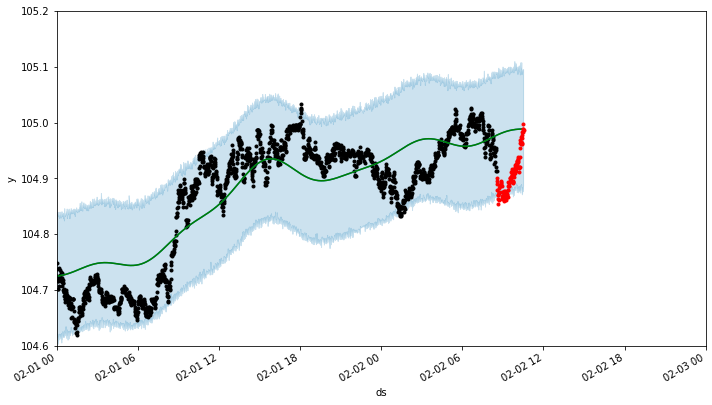

In [105]:
fig = m.plot(forecast)
forecast.set_index('ds')['yhat'].plot(color='g')
df_test.set_index('ds')['y'].plot(color='r', linestyle='', marker='.')

max_dt = datetime.datetime.strptime('20210203', '%Y%m%d')
min_dt = datetime.datetime.strptime('20210201', '%Y%m%d')
plt.xlim(min_dt, max_dt)
plt.ylim(104.6, 105.2)
plt.show()

In [113]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [116]:
df_cv = cross_validation(m, horizon='1 days')
df_p = performance_metrics(df_cv)

Exception ignored in: <function tqdm.__del__ at 0x7f598a946310>
Traceback (most recent call last):
  File "/home/ryoji/.cache/pypoetry/virtualenvs/trade-Pm8PR6AO-py3.8/lib/python3.8/site-packages/tqdm/std.py", line 1134, in __del__
    self.close()
  File "/home/ryoji/.cache/pypoetry/virtualenvs/trade-Pm8PR6AO-py3.8/lib/python3.8/site-packages/tqdm/notebook.py", line 280, in close
    self.disp(bar_style='danger')
AttributeError: 'tqdm' object has no attribute 'disp'
INFO:fbprophet:Making 31 forecasts with cutoffs between 2021-01-11 09:59:00 and 2021-02-01 08:32:00


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
df_p

In [ ]:
df_p.describe()

In [115]:
!poetry add jupyterlab_widgets

Using version ^1.0.0 for jupyterlab-widgets

Updating dependencies
Resolving dependencies... (0.3s)

Writing lock file

No dependencies to install or update
